In [5]:
# Install libs

!pip install beautifulsoup4
!pip install requests
!pip install fake_useragent
!pip install pandas numpy
!pip install matplotlib
!pip install lxml

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 7.3 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 10.2 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 KB 7.8 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00m eta 0:00:010:01:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Defaulting to user installation because normal site-packages is not writeable


In [34]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from fake_useragent import UserAgent

from bs4 import BeautifulSoup
from lxml import etree
import json

import warnings
warnings.filterwarnings("ignore")

from time import sleep

import os

In [46]:
# Find all links to articles

user_agent = UserAgent().chrome

base_url = 'https://habr.com'
main_link = 'https://habr.com/ru/hubs/popular_science/articles/'
links_file = 'habr_urls.txt'
dir_name = 'habr_pages'
file_names = dir_name + '/page{}.txt'

In [24]:
# Find all links on main page

res = requests.get(main_link, headers={'User-Agent': user_agent})
bs = BeautifulSoup(res.content, 'html.parser')
# print(bs.prettify())
links = bs.find_all('a', attrs={'class': 'tm-title__link'})
links

[<a class="tm-title__link" data-article-link="true" data-test-id="article-snippet-title-link" href="/ru/articles/843302/"><span>Гайд по психопатам с научным подходом</span></a>,
 <a class="tm-title__link" data-article-link="true" data-test-id="article-snippet-title-link" href="/ru/articles/843292/"><span>Невероятная история господина президента</span></a>,
 <a class="tm-title__link" data-article-link="true" data-test-id="article-snippet-title-link" href="/ru/articles/843224/"><span>Современные детекторы рентгеновского излучения</span></a>,
 <a class="tm-title__link" data-article-link="true" data-test-id="article-snippet-title-link" href="/ru/articles/843278/"><span>ЧГК-GPT, или насколько хорош новый ChatGPT o1-preview в спортивном «Что? Где? Когда?»</span></a>,
 <a class="tm-title__link" data-article-link="true" data-test-id="article-snippet-title-link" href="/ru/articles/843238/"><span>Диалектика vs Хаос: Или почему Гегель перевернулся бы в гробу</span></a>,
 <a class="tm-title__link"

# Collect url's from pages and save it to file 'habr_urls.txt'

In [10]:
# Get url from html block
def clear_links(links):
    urls = []
    for i in links:
        urls.append(i['href'])

    return urls

clear_links(links)

['/ru/articles/843302/',
 '/ru/articles/843292/',
 '/ru/articles/843224/',
 '/ru/articles/843278/',
 '/ru/articles/843238/',
 '/ru/articles/843234/',
 '/ru/companies/kaspersky/articles/842244/',
 '/ru/companies/timeweb/articles/843108/',
 '/ru/articles/843106/',
 '/ru/articles/842584/',
 '/ru/companies/first/articles/843096/',
 '/ru/articles/842646/',
 '/ru/companies/ua-hosting/articles/842418/',
 '/ru/articles/842988/',
 '/ru/articles/842908/',
 '/ru/companies/ru_mts/articles/842904/',
 '/ru/articles/842882/',
 '/ru/specials/842562/',
 '/ru/companies/mclouds/articles/842470/',
 '/ru/articles/842484/']

In [11]:
def crawler(url):
    res = requests.get(url, headers={'User-Agent': user_agent})
    bs = BeautifulSoup(res.content, 'html.parser')
    links = bs.find_all('a', attrs={'class': 'tm-title__link'})
    return links

In [36]:
def save_links(links):
    with open(links_file, 'a') as f:
        links[-1] += '\n'
        f.write('\n'.join(links))

# save_links(clear_links(links))

In [27]:
articles = 5000
links_per_page = len(links)
amount_of_pages = int(articles / links_per_page)
print('Total pages:', amount_of_pages)

for i in range(1, amount_of_pages):
    url = f'{main_link}page{i}/'
    print(f'[{i}] url: {url}')
    links = crawler(url)
    links = clear_links(links)
    save_links(links)
    sleep(5)

Total pages: 250
[1] url: https://habr.com/ru/hubs/popular_science/articles/page1/
[2] url: https://habr.com/ru/hubs/popular_science/articles/page2/


# Create functions to get pages and store it as json file 

In [39]:
# Create folder to store articles as json

os.mkdir(dir_name)

In [33]:
# Class, that downloads page and gets some features from it

class PageInfo:
    def __init__(self, url, user_agent):
        self.url = url
        self.res = requests.get(self.url, headers={'User-Agent': user_agent})
        self.bs = BeautifulSoup(self.res.content, 'html.parser')
        
    def get_title(self):
        return self.bs.title.text

    def get_tags(self):
        tags = self.bs.find_all('span', attrs={'class': 'tm-publication-hub__link-container'})
        tags = [i.text for i in tags]
        return tags

    def get_read_time(self):
        read_time = self.bs.find('span', attrs={'class': 'tm-article-reading-time__label'})
        return read_time.text

    def get_number_of_views(self):
        number_of_views = self.bs.find('span', attrs={'class': 'tm-icon-counter__value'})
        return number_of_views.text

    def get_date(self):
        date = self.bs.find('time')
        return date['title']

    def get_amount_of_images(self):
        dom = etree.HTML(self.res.content)
        imgs = dom.xpath('//*[@id="post-content-body"]/div/div/div/img')
        return len(imgs)

    def get_comments(self):
        comments = self.bs.find('span', attrs={'class': 'tm-article-comments-counter-link__value'})
        return comments.text

    def get_bookmarks(self):
        bookmark = self.bs.find('span', attrs={'class': 'bookmarks-button__counter'})
        return bookmark.text

    def get_votes(self):
        votes = self.bs.find('span', attrs={'class': 'tm-votes-meter__value'})
        if votes == None:
            return 0
        return votes.text

    def get_text(self):
        text = self.bs.find('div', attrs={'class': 'tm-article-body'})
        return text.text.strip()

    def get_json(self):
        tags = self.get_tags()
        return json.dumps({'url': self.url,
               'title': self.get_title(),
               'theme': tags[0] if len(tags) > 0 else '',
               'tags': tags,
               'read_time': self.get_read_time(),
               'number_of_views': self.get_number_of_views(),
               'date': self.get_date(),
               'amount_of_imgs': self.get_amount_of_images(),
               'comments': self.get_comments(),
               'bookmark': self.get_bookmarks(),
               'votes': self.get_votes(),
               'text': self.get_text()})


In [34]:
# Test class
page = PageInfo('https://habr.com/ru/companies/timeweb/articles/687076/', user_agent)
json.loads(page.get_json())

{'url': 'https://habr.com/ru/companies/timeweb/articles/687076/',
 'title': 'Настолки Древней Руси / Хабр',
 'theme': 'Блог компании Timeweb Cloud',
 'tags': ['Блог компании Timeweb Cloud',
  'Разработка игр*',
  'Научно-популярное',
  'Игры и игровые консоли',
  'Логические игры'],
 'read_time': '7 мин',
 'number_of_views': '21K',
 'date': '2022-09-17, 16:38',
 'amount_of_imgs': 15,
 'comments': '20',
 'bookmark': '58',
 'votes': '+59',
 'text': 'В продолжение темы древних игр (Во что поиграть, если шахматы ещё не придумали, а ты фараон/викинг/вождь майя), я решила узнать, во что играли в Древней Руси. \n\nПод катом фотки, правила и ссылочки на браузерные версии «монополий» и «три в ряд» времен средневековой Руси.\n\nЯ веду канал в Telegram GameDEVils и блог на Substack . Подписывайтесь, я делюсь там материалами про геймдизайн, разработку и историю игр. \n\nИгры в кости\nБояре Владимира Святославича мечут жребий для определения жертвы языческим богам. Миниатюра радзивилловской летопис

# Parser

In [40]:
# Read all links from file

links = []
with open(links_file, 'r') as f:
    a = f.read()
    links = a.split('\n')
links = links[:-1]

In [47]:
# Download page by page and save it to json

for i in enumerate(links):
    url = base_url + i[1]
    print(f'[{i[0]}] Load: {url}')
    page = PageInfo(url, user_agent)
    
    with open(file_names.format(i[0]), 'w') as f:
        f.write(page.get_json())
        sleep(0.5)

[0] Load: https://habr.com/ru/articles/843302/
[1] Load: https://habr.com/ru/articles/843292/
[2] Load: https://habr.com/ru/articles/843224/
[3] Load: https://habr.com/ru/articles/843278/
[4] Load: https://habr.com/ru/articles/843238/


KeyboardInterrupt: 

# Create dataset

In [48]:
os.listdir(dir_name)

['page2.txt', 'page0.txt', 'page4.txt', 'page3.txt', 'page1.txt']

In [51]:
# Upload files function

def get_json(id):
    with open(file_names.format(id), 'r') as f:
        return json.loads(f.read())

In [55]:
files = os.listdir(dir_name)
amount_of_files = len(files)
pages = [get_json(i) for i in range(amount_of_files)]

In [58]:
# Create Dataframe

df = pd.DataFrame(pages)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              5 non-null      object
 1   title            5 non-null      object
 2   theme            5 non-null      object
 3   tags             5 non-null      object
 4   read_time        5 non-null      object
 5   number_of_views  5 non-null      object
 6   date             5 non-null      object
 7   amount_of_imgs   5 non-null      int64 
 8   comments         5 non-null      object
 9   bookmark         5 non-null      object
 10  votes            5 non-null      int64 
 11  text             5 non-null      object
dtypes: int64(2), object(10)
memory usage: 608.0+ bytes


In [59]:
df = df.drop_duplicates(subset=['url'])

In [62]:
# Convert numerical data to int

df['number_of_views'] = df['number_of_views'].map(lambda x: x if not 'K' in x else float(x[:-1]) * 1000)
df['read_time'] = df['read_time'].map(lambda x: x[:-4])
df = df.astype({i:np.int32 for i in ['amount_of_imgs', 'comments', 'bookmark', 'votes', 'number_of_views', 'read_time']})
df['date'] = pd.to_datetime(df['date'])

In [63]:
# Save dataset

df.to_csv('habr_dataset.csv', index=False)

# Upload dataset

In [3]:
df = pd.read_csv('habr_dataset.csv')
df['date'] = pd.to_datetime(df['date'])

In [66]:
df

,url,title,theme,tags,read_time,number_of_views,date,amount_of_imgs,comments,bookmark,votes,text
0,https://habr.com/ru/articles/842474/,На Alibaba можно купить станок для изготовлени...,Научно-популярное,"['Научно-популярное', 'Физика']",4,2800,2024-09-11 14:58:00,0,4,3,0,"Производство бриллиантов стало дешевле, чем ко..."
1,https://habr.com/ru/articles/842336/,"Учёные, искавшие жизнь на Марсе, услышали сигн...",Научно-популярное,"['Научно-популярное', 'Астрономия']",8,1600,2024-09-11 13:38:00,0,1,2,0,"В 1924 году радиоприёмник, созданный для полей..."
2,https://habr.com/ru/companies/montirey/article...,Проявление свойств эфира: доказано эксперимент...,Блог компании Мон Тирэй,"['Блог компании Мон Тирэй', 'Научно-популярное...",7,3700,2024-09-11 11:24:00,0,44,5,0,Исследования российских учёных подтвердили сущ...
3,https://habr.com/ru/companies/timeweb/articles...,Деннис Макалистэйр Ритчи. Между Unix и С / Хабр,Блог компании Timeweb Cloud,"['Блог компании Timeweb Cloud', 'Читальный зал...",18,1300,2024-09-11 11:05:00,0,0,11,0,Создатель.Точнее всего описывает Денниса Ритчи...
4,https://habr.com/ru/articles/842324/,Болезнь Альцгеймера может оказаться аутоиммунн...,Научно-популярное,"['Научно-популярное', 'Мозг', 'Здоровье']",4,840,2024-09-11 10:49:00,0,0,4,0,Поиски лекарства от болезни Альцгеймера станов...
...,...,...,...,...,...,...,...,...,...,...,...,...
4333,https://habr.com/ru/companies/ua-hosting/artic...,Ритм на кончиках пальцев: считывание сигналов ...,Блог компании ua-hosting.company,"['Блог компании ua-hosting.company', 'Научно-п...",13,2100,2021-08-11 15:21:00,6,0,20,13,Мы воспринимаем окружающий мир посредством наб...
4334,https://habr.com/ru/articles/572266/,Фомальгаут / Хабр,Научно-популярное,"['Научно-популярное', 'Астрономия']",4,17000,2021-08-10 23:56:00,7,20,37,47,Альфа Южной рыбы\n\n\nУвидеть Фомальгаут в Мос...
4335,https://habr.com/ru/articles/572046/,Морской чёртик и морской ангел / Хабр,Научно-популярное,"['Научно-популярное', 'Биология']",5,9400,2021-08-10 21:52:00,0,7,11,11,"Минуточку внимания:Как-то так получается, что ..."
4336,https://habr.com/ru/companies/ruvds/articles/5...,Ретротехнологии. Нувистор – последнее слово в ...,Блог компании RUVDS.com,"['Блог компании RUVDS.com', 'Производство и ра...",3,17000,2021-08-10 20:00:00,0,34,40,40,Статья посвящена многим неизвестному типу ради...


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              4338 non-null   object
 1   title            4338 non-null   object
 2   theme            4338 non-null   object
 3   tags             4338 non-null   object
 4   read_time        4338 non-null   int64 
 5   number_of_views  4338 non-null   int64 
 6   date             4338 non-null   object
 7   amount_of_imgs   4338 non-null   int64 
 8   comments         4338 non-null   int64 
 9   bookmark         4338 non-null   int64 
 10  votes            4338 non-null   int64 
 11  text             4338 non-null   object
dtypes: int64(6), object(6)
memory usage: 406.8+ KB


In [68]:
df.describe()

,read_time,number_of_views,amount_of_imgs,comments,bookmark,votes
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,9.172430,14362.485708,2.635316,41.607423,42.133472,31.970724
std,6.182585,20408.792136,6.774831,88.108662,54.931823,39.051863
min,1.000000,479.000000,0.000000,0.000000,0.000000,-102.000000
25%,5.000000,3900.000000,0.000000,5.000000,16.000000,9.000000
50%,8.000000,7600.000000,0.000000,15.000000,28.000000,20.000000
75%,11.000000,16000.000000,1.000000,42.000000,48.000000,42.000000
max,89.000000,307000.000000,114.000000,1961.000000,1139.000000,540.000000


In [70]:
len(df['text'][0])

6862

# Create graphs

Text(0, 0.5, 'Amount of articles')

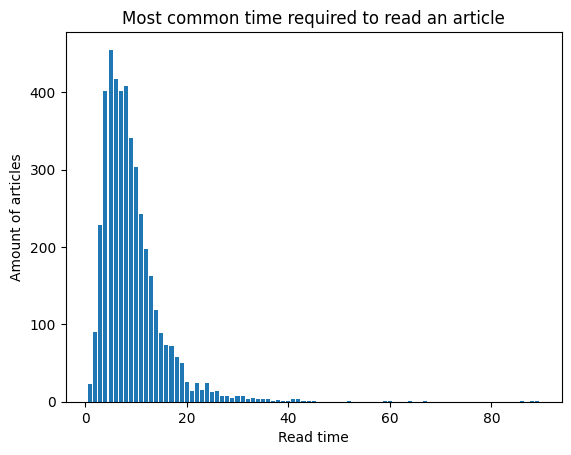

In [76]:
x = df.groupby('read_time').count()

plt.bar(x.index, x['url'])

plt.title('Most common time required to read an article')
plt.xlabel('Read time')
plt.ylabel('Amount of articles')

Text(0, 0.5, 'Amount of articles')

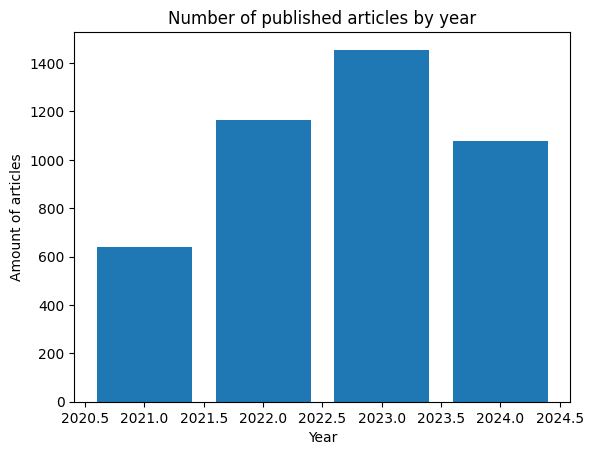

In [15]:
x = df.groupby(pd.Grouper(key='date', axis=0, freq='Y')).count()

plt.bar(x.index.year, x['url'])

plt.title('Number of published articles by year')
plt.xlabel('Year')
plt.ylabel('Amount of articles')

Text(0.5, 1.0, 'Top 10 popular topics')

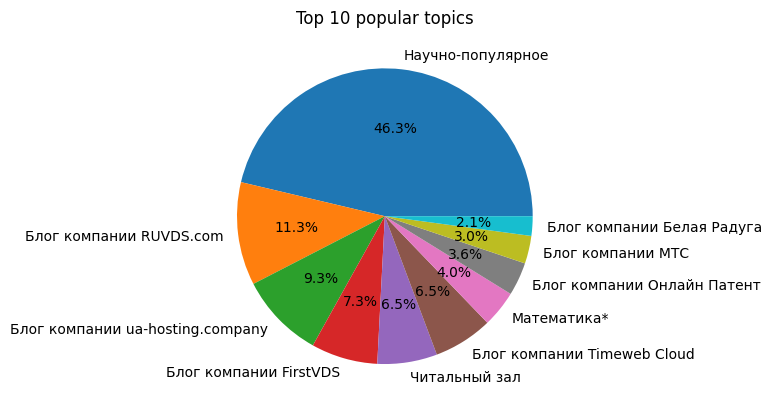

In [37]:
x = df.groupby('theme').count()
x = x.sort_values(by='url', ascending = False)[:10]

plt.pie(x['url'], labels=x.index, autopct='%1.1f%%')
plt.title('Top 10 popular topics')

Text(0, 0.5, 'Amount of articles')

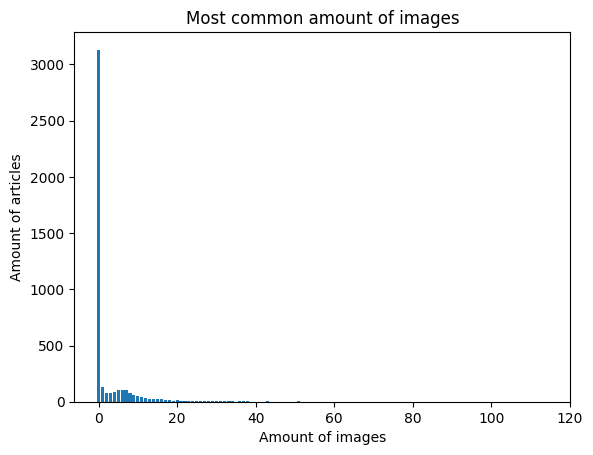

In [40]:
x = df.groupby('amount_of_imgs').count()

plt.bar(x.index, x['url'])

plt.title('Most common amount of images')
plt.xlabel('Amount of images')
plt.ylabel('Amount of articles')